# Frame the Problem and Look at the Big Picture 

1. Define the objective in business terms.
- The objective is to predict which squirrels are 
   sick and which are healthy.<!-- (I think confirm this derek) -->-
- our client is part of the Squirrel census and is interested in the health of the squirrels in Central Park.
- The goal is to predict weather or not a squirrel has a certain disease or not.
2. How will your solution be used?
- The solution will be used to predict the health of the squirrels in Central Park. This could save time and money for the Squirrel census.
3. What are the current solutions/workarounds (if any)?
- The current solution is to send out a team of experts to check the health of the squirrels.
- This is time consuming and expensive, and the team can only check a limited number of squirrels.
4. How should you frame this problem (supervised/unsupervised, online/offline, etc.)?
- This is a supervised learning problem because we have labeled data, and it is to be trained on an online capable system.
5. How should performance be measured?
- The performance should be measured using the F1 score, as we want to have a balance between precision and recall.\
6. What would be the minimum performance needed to reach the business objective?
- The minimum performance needed to reach the business objective is an F1 score of ???
7. What are comparable problems? Can you reuse experience or tools?
- This is a classification problem, and we can use the tools and experience from other classification problems. Data from previous experiences might be used in addition to the tools.
8. Is human expertise available?
- Yes, human expertise is availabe. Our client is part of the Squirrel census and has a lot of knowledge about the health of the squirrels in Central Park.
9. How would you solve the problem manually?
- The problem could be solved manually by sending out a team of experts to check the health of the squirrels.
10. List the assumptions you (or others) have made so far.
- The data is accurate and up to date.
- The data is labeled correctly.


# Get the Data

1. List the data you need and how much you need.
   - We will need the diseased squirrel data which was provided by the client and the 2018 squirrel census data, along with weather data that is realevent to the target area. 
2. Find and document where you can get that data.
    - The data was obtained from the [NYC OpenData Collections](https://data.cityofnewyork.us/Environment/2018-Central-Park-Squirrel-Census-Squirrel-Data/vfnx-vebw/about_data), [Weather Data](https://www.ncei.noaa.gov/data/daily-summaries/doc/GHCND_documentation.pdf)  and obtained from the client.
    
3. Get access authorizations.
    - N/A
4. Create a workspace (with enough storage space).
    - N/A
5. Get the data.
    - N/A
6. Convert the data to a format you can easily manipulate (without changing the data itself).
    - The data is in three separate CSV files. We will load the data into a pandas DataFrame, and combine the data into a single DataFrame. (to be easily manipulated)
7. Ensure sensitive information is deleted or protected (e.g. anonymized).
    - N/A
8. Check the size and type of data (time series, sample, geographical, etc.).
    - The data is sample data and includes location data for each of the squirrels. 
9. Sample a test set, put it aside, and never look at it (no data snooping!).
    - We will sample 10% of the data and put it aside.

In [199]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from pandas.tseries.offsets import MonthEnd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
import warnings
from sklearn.exceptions import DataConversionWarning

# Suppress all  warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
#suppress warnings from gridsearch and gridsearchcv
warnings.filterwarnings(action='ignore', category=FutureWarning, module='sklearn')
warnings.filterwarnings(action='ignore', category=DeprecationWarning, module='sklearn')
warnings.filterwarnings(action='ignore', category=RuntimeWarning, module='sklearn')
warnings.filterwarnings(action='ignore', category=UserWarning, module='sklearn')


set_config(transform_output = "pandas")

In [200]:
def load_data(census_data="2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20241105.csv",ad_viz_data="ad_viz_plotval_data.csv",
              co2air_data="co2air.csv", disease_data="diseased_squirrels.csv", no2_data="NO2.csv", pbair_data="Pbair.csv",
              weather_data="weather.csv"):
    
    #load the data
    census = pd.read_csv(census_data)
    ad_viz = pd.read_csv(ad_viz_data)
    co2air = pd.read_csv(co2air_data)
    disease = pd.read_csv(disease_data,header=None)
    no2 = pd.read_csv(no2_data)
    pbair = pd.read_csv(pbair_data)
    weather = pd.read_csv(weather_data)

    return census, ad_viz, co2air, disease, no2, pbair, weather

load_data()


(              X          Y Unique Squirrel ID Hectare Shift      Date  \
 0    -73.956134  40.794082     37F-PM-1014-03     37F    PM  10142018   
 1    -73.968857  40.783783     21B-AM-1019-04     21B    AM  10192018   
 2    -73.974281  40.775534     11B-PM-1014-08     11B    PM  10142018   
 3    -73.959641  40.790313     32E-PM-1017-14     32E    PM  10172018   
 4    -73.970268  40.776213     13E-AM-1017-05     13E    AM  10172018   
 ...         ...        ...                ...     ...   ...       ...   
 3018 -73.963943  40.790868     30B-AM-1007-04     30B    AM  10072018   
 3019 -73.970402  40.782560     19A-PM-1013-05     19A    PM  10132018   
 3020 -73.966587  40.783678     22D-PM-1012-07     22D    PM  10122018   
 3021 -73.963994  40.789915     29B-PM-1010-02     29B    PM  10102018   
 3022 -73.975479  40.769640      5E-PM-1012-01     05E    PM  10122018   
 
       Hectare Squirrel Number    Age Primary Fur Color  \
 0                           3    NaN              

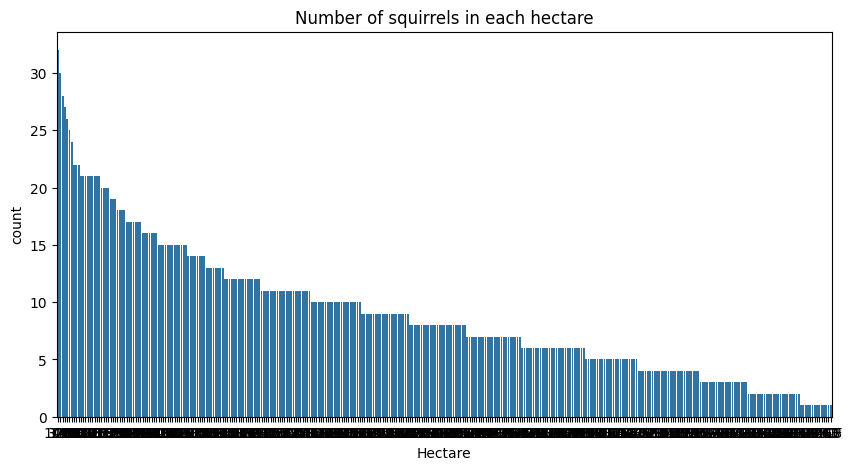

In [201]:

# Load the data
census, ad_viz, co2air, disease, no2, pbair, weather = load_data()

#plot of the number of squirrels in each hectare
def plot_squirrel_density(census):
    #plot the number of squirrels in each hectare
    plt.figure(figsize=(10,5))
    sns.countplot(x='Hectare', data=census, order=census['Hectare'].value_counts().index)
    plt.title('Number of squirrels in each hectare')
    plt.show()


plot_squirrel_density(census)
    

In [202]:
percent_missing = census.isnull().mean() * 100
missing_value_df = pd.DataFrame({'column_name': census.columns,
                                 'percent_missing': percent_missing})

print(missing_value_df)


---
Going through the census data we have found that there is a large percentage of missing values in the columns for :
* Color notes 
* Specific Location    
* Other Activities
* Other Interactions  
* Highlight Fur Color 

These columns have 80-90% missing values  with highlight fur color having the lowest ammount with 35% missing values. The location, activites, and interactions are all what the recorders observed and will not be in a format that can be easily usable without modification. It is possible to use a vector search and see if there are any correlations based on the language used but this will not be used as a primary focus for finding corelations at the moment. 

In [203]:
#heatmap of missing values
plt.figure(figsize=(10,5))
sns.heatmap(census.isnull(), cbar=False)
plt.title('Heatmap of missing values')
plt.show()


In [204]:
#create a list of unique values in other activities and other interactions 
other_activities = census['Other Activities'].unique()
other_interactions = census['Other Interactions'].unique()

# print the unique values in other activities and other interactions
print(other_activities)
print(other_interactions)


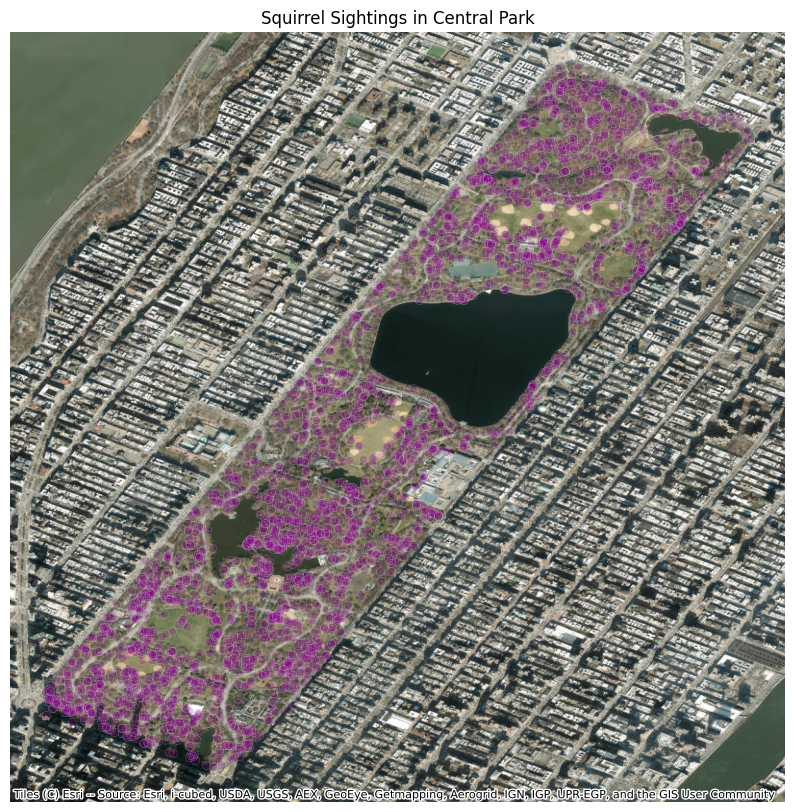

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import pandas as pd

def plot_squirrel_map(census):
    # Create a GeoDataFrame for the census data
    gdf = gpd.GeoDataFrame(census, geometry=gpd.points_from_xy(census.X, census.Y))
    gdf = gdf.set_crs(epsg=4326)  # Assuming WGS84 CRS for input data
    
    # Convert the GeoDataFrame to Web Mercator for compatibility with basemaps
    gdf = gdf.to_crs(epsg=3857)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the scatterplot for squirrel sightings
    sns.scatterplot(x=gdf.geometry.x, y=gdf.geometry.y, data=gdf, alpha=0.2, ax=ax, color="purple")

    # Add the basemap
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    # Customize the plot
    ax.set_title('Squirrel Sightings in Central Park')
    ax.set_axis_off()

    # Show the plot
    plt.show()

# Provided points

data3 = census[['X', 'Y']]
# Call the function
plot_squirrel_map(data3)


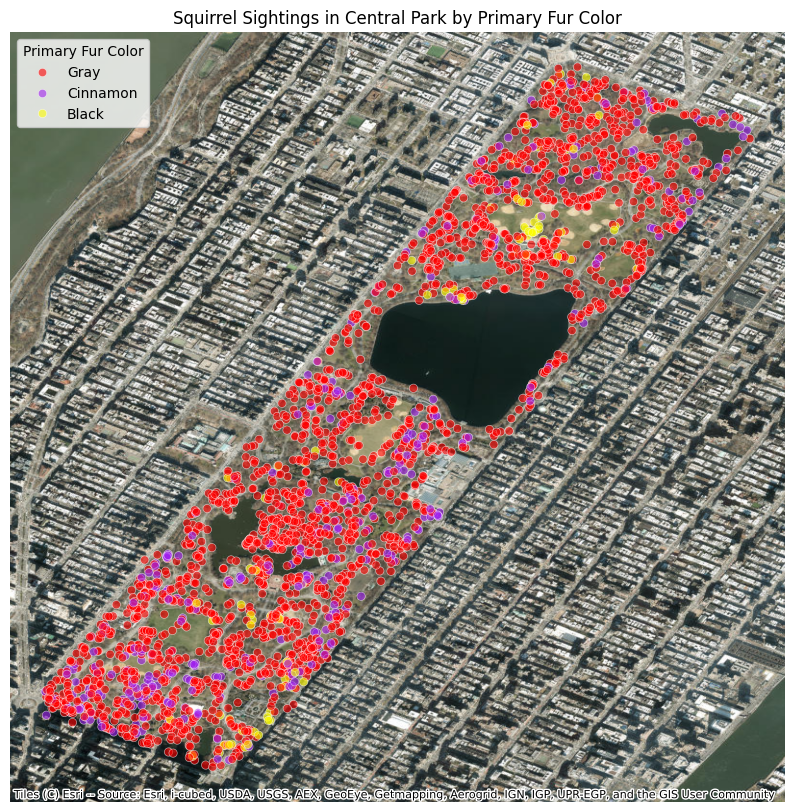

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx

def plot_squirrel_map_with_custom_palette(census, custom_palette):
    # Create a GeoDataFrame for the census data
    gdf = gpd.GeoDataFrame(census, geometry=gpd.points_from_xy(census.X, census.Y))
    gdf = gdf.set_crs(epsg=4326)  # Assuming WGS84 CRS for input data
    
    # Convert the GeoDataFrame to Web Mercator for compatibility with basemaps
    gdf = gdf.to_crs(epsg=3857)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the scatterplot for squirrel sightings with custom palette
    sns.scatterplot(
        x=gdf.geometry.x, 
        y=gdf.geometry.y, 
        data=gdf, 
        hue="Primary Fur Color", 
        alpha=0.6, 
        ax=ax, 
        palette=custom_palette  # Custom color palette
    )

    # Add the basemap
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    # Customize the plot
    ax.set_title('Squirrel Sightings in Central Park by Primary Fur Color')
    ax.set_axis_off()

    # Show the plot
    plt.show()

# Define a custom palette (example)
custom_palette = {
    "Gray": "#ff0000",       # Red
    "Cinnamon": "#a020f0",   # Purple (example, you can adjust this)
    "Black": "#ffff00",      # Black
}


# Call the function with your census data and custom palette
plot_squirrel_map_with_custom_palette(census, custom_palette)


In [231]:
# Load your data
census, ad_viz, co2air, disease, no2, pbair, weather = load_data()

# Clean disease data (list of IDs)
diseased_ids = disease[0].tolist()

# Create a 'Diseased' column in the census data
census['Diseased'] = census['Unique Squirrel ID'].isin(diseased_ids)


In [232]:
# Compare age distribution
age_counts = census.groupby(['Age', 'Diseased']).size().unstack()
print(age_counts)

# Chi-squared test for fur color

fur_color_table = pd.crosstab(census['Primary Fur Color'], census['Diseased'])
chi2, p, dof, ex = chi2_contingency(fur_color_table)
print(f"P-value for fur color difference: {p}")


In [233]:
# Bar chart for fur color
fur_color_counts = census.groupby(['Primary Fur Color', 'Diseased']).size().unstack()
fur_color_counts.plot(kind='bar', stacked=True)
plt.title('Fur Color Distribution')
plt.xlabel('Primary Fur Color')
plt.ylabel('Number of Squirrels')
plt.show()


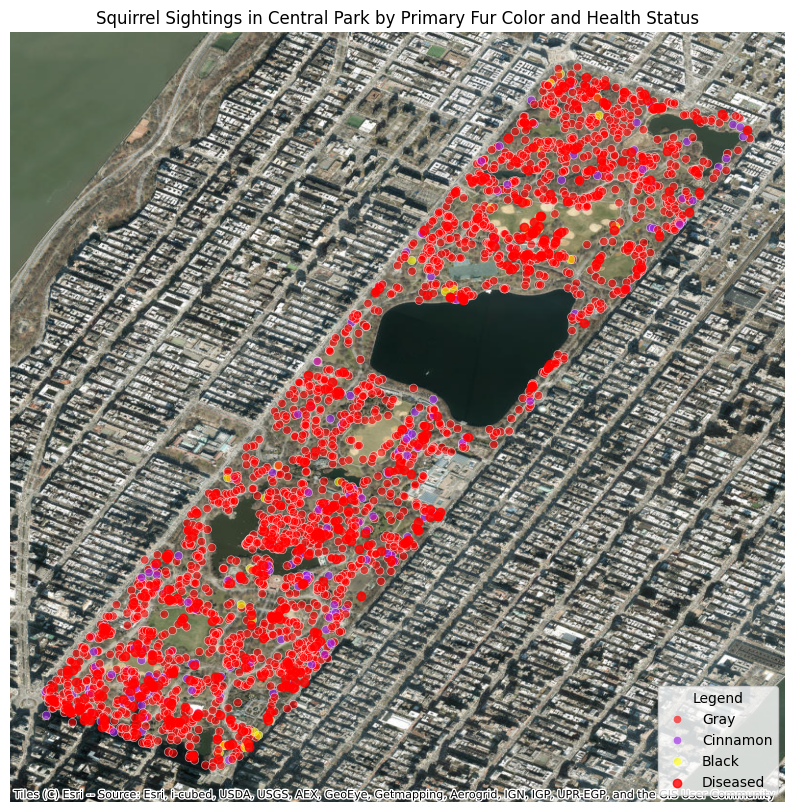

In [240]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx

def plot_squirrel_map_with_custom_palette_and_highlights(census, custom_palette):
    # Create a GeoDataFrame for the census data
    gdf = gpd.GeoDataFrame(census, geometry=gpd.points_from_xy(census.X, census.Y))
    gdf = gdf.set_crs(epsg=4326)  # Assuming WGS84 CRS for input data

    # Convert the GeoDataFrame to Web Mercator for compatibility with basemaps
    gdf = gdf.to_crs(epsg=3857)

    # Separate healthy and diseased squirrels
    healthy_squirrels = gdf[~gdf['Diseased']]  # Not diseased
    diseased_squirrels = gdf[gdf['Diseased']]  # Diseased

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot healthy squirrels with custom palette
    sns.scatterplot(
        x=healthy_squirrels.geometry.x, 
        y=healthy_squirrels.geometry.y, 
        data=healthy_squirrels, 
        hue="Primary Fur Color", 
        alpha=0.6, 
        ax=ax, 
        palette=custom_palette  # Custom color palette
    )

    # Plot diseased squirrels with a separate color
    plt.scatter(
        diseased_squirrels.geometry.x, 
        diseased_squirrels.geometry.y, 
        c='red', 
        label='Diseased', 
        alpha=0.8
    )

    # Add the basemap
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    # Customize the plot
    ax.set_title('Squirrel Sightings in Central Park by Primary Fur Color and Health Status')
    ax.set_axis_off()
    ax.legend(title="Legend", loc='lower right')

    # Show the plot
    plt.show()

# Define a custom palette (example)
custom_palette = {
    "Gray": "#ff0000",       # Red
    "Cinnamon": "#a020f0",   # Purple
    "Black": "#ffff00",      # Yellow for black fur
}

# Call the function with your census data and custom palette
plot_squirrel_map_with_custom_palette_and_highlights(census, custom_palette)


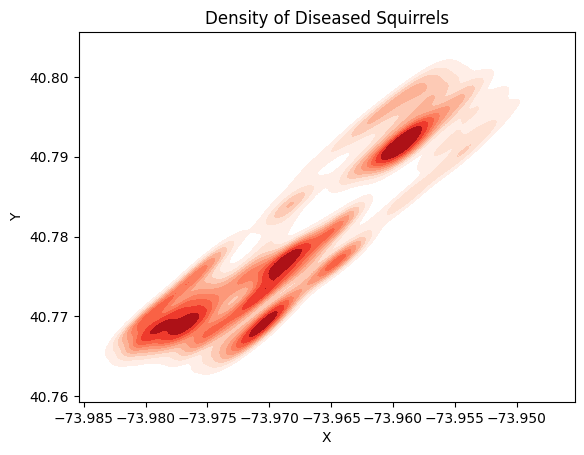

In [235]:
# Density Estimation plot for diseased squirrels
sns.kdeplot(x=diseased_squirrels['X'], y=diseased_squirrels['Y'], cmap="Reds", shade=True, bw_adjust=.5)
plt.title('Density of Diseased Squirrels')
plt.show()


In [236]:
# plot the percentage of squirrels that are diseased and not diseased by behavior
behaviors = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging']









In [237]:
census['Date'] = pd.to_datetime(census['Date'], format='%m%d%Y')

# Time series plot
census.set_index('Date', inplace=True)
disease_time_series = census.groupby('Date')['Diseased'].sum()

plt.figure(figsize=(12, 6))
disease_time_series.plot()
plt.title('Number of Diseased Squirrels Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Diseased Squirrels')
plt.show()


In [ ]:
age_counts = census.groupby(['Age', 'Diseased']).size().unstack()
age_counts.plot(kind='bar', stacked=True)
plt.title('Age Distribution by Disease Status')
plt.xlabel('Age')
plt.ylabel('Number of Squirrels')
plt.show()


In [ ]:
# find the percentage of dieased squirrels with Other Activities, and Other Interactions and list the 
# activities and interactions where diseased squirrels are more than 50% of the total number of squirrels

# Percentage of diseased squirrels with Other Activities
other_activities_counts = census.groupby(['Other Activities', 'Diseased']).size().unstack()
other_activities_counts['Percentage Diseased'] = other_activities_counts[True] / other_activities_counts.sum(axis=1)
print(other_activities_counts)

# Percentage of diseased squirrels with Other Interactions
other_interactions_counts = census.groupby(['Other Interactions', 'Diseased']).size().unstack()
other_interactions_counts['Percentage Diseased'] = other_interactions_counts[True] / other_interactions_counts.sum(axis=1)
print(other_interactions_counts)

# Activities where diseased squirrels are more than 50% of the total number of squirrels
activities_over_50 = other_activities_counts[other_activities_counts['Percentage Diseased'] > 0.5]
print(activities_over_50)

# Interactions where diseased squirrels are more than 50% of the total number of squirrels
interactions_over_50 = other_interactions_counts[other_interactions_counts['Percentage Diseased'] > 0.5]
print(interactions_over_50)





---
To see if there could be a correlation between the 

In [ ]:
print(weather.head())

In [ ]:
# Reset index to access 'Date' column
census.reset_index(inplace=True)

# Convert date column in census and weather data to datetime
census['Date'] = pd.to_datetime(census['Date'], format='%m%d%Y')
weather['DATE'] = pd.to_datetime(weather['DATE'], format='%Y-%m-%d')

# Merge the census and weather data on the date column
census_weather = pd.merge(census, weather, left_on='Date', right_on='DATE', how='inner')

# Align date range to census data
census_weather = census_weather[(census_weather['Date'] >= '2018-10-01') & (census_weather['Date'] <= '2018-10-31')]

print(census_weather.head())


In [143]:
#create a correlation matrix of the census_weather data and plot a heatmap of the correlation matrix

#select only the numeric columns
census_weather_numeric = census_weather.select_dtypes(include=[np.number])




In [ ]:
# correlation matrix of behavioral features and the 'Diseased' column

#select only the behavioral features and the 'Diseased' column

behavioral_features = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging','Kuks','Quaas','Moans','Tail flags','Tail twitches','Approaches','Indifferent','Runs from']

behavioral_features_diseased = census_weather[behavioral_features + ['Diseased']]
behavioral_features_diseased = behavioral_features_diseased.dropna()

correlation_matrix = behavioral_features_diseased.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='seismic', center=0)
plt.title('Correlation Matrix of Behavioral Features and Disease Status')
plt.show()


In [145]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Replace NaN values with an empty string
census_weather['Other Activities'] = census_weather['Other Activities'].fillna("")
census_weather['Other Interactions'] = census_weather['Other Interactions'].fillna("")
census_weather['Specific Location'] = census_weather['Specific Location'].fillna("")


# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on the 'Other Activities' column
other_activities_tfid = vectorizer.fit_transform(census_weather['Other Activities'])

other_interactions_tfid = vectorizer.fit_transform(census_weather['Other Interactions'])

specific_location_tfid = vectorizer.fit_transform(census_weather['Specific Location'])

In [146]:
# Combine the 'Age' and 'Primary Fur Color' columns to create a stratification group
census_weather['Stratify_Group'] = census_weather['Age'].astype(str) + "_" +\
      census_weather['Primary Fur Color'].astype(str)


In [147]:
#drop columns that have 100% missing values
census_weather = census_weather.dropna(axis=1, how='all')

In [148]:


# list of features to drop
features_to_drop = ['X', 'Y', 'Shift', 'STATION','NAME','LATITUDE','LONGITUDE',
                    'ELEVATION','PRCP_ATTRIBUTES','SNOW','SNOW_ATTRIBUTES','SNWD'
                    ,'SNWD_ATTRIBUTES','TMAX_ATTRIBUTES','TMIN_ATTRIBUTES','WT01','WT01_ATTRIBUTES',
                    'AWND_ATTRIBUTES','PRCP_ATTRIBUTES','WDF2_ATTRIBUTES', 'WDF5_ATTRIBUTES',
                    'WSF2_ATTRIBUTES', 'WSF5_ATTRIBUTES','WT08', 'WT08_ATTRIBUTES']


# function to drop the features
def drop_features(data, features_to_drop):
    data = data.drop(features_to_drop, axis=1)
    return data



In [149]:
census_weather = drop_features(census_weather, features_to_drop)



| Vector             | OneHot                                     | Numerical                                                     | Other                   |   |
|--------------------|--------------------------------------------|---------------------------------------------------------------|-------------------------|---|
| Color notes        | Age                                        | Above Ground Sighter Measurement  (need to change false to 0) | Unique Squirrel ID      |   |
| Specific Location  | Primary Fur Color                          | AWND                                                          | Hectare                 |   |
| Other Activities   | Highlight Fur Color                        | PRCP                                                          | Date                    |   |
| Other Interactions | Combination of Primary and Highlight Color | TMAX                                                          | Hectare Squirrel Number |   |
|                    | Location                                   | TMIN                                                          | Lat/Long                |   |
|                    | Running                                    | WDF2                                                          |                         |   |
|                    | Chasing                                    | WDF5                                                          |                         |   |
|                    | Climbing                                   | WSF2                                                          |                         |   |
|                    | Eating                                     | WSF5                                                          |                         |   |
|                    | Foraging                                   | Hectare Squirrel Number                                       |                         |   |
|                    | Kuks                                       |                                                               |                         |   |
|                    | Quaas                                      |                                                               |                         |   |
|                    | Moans                                      |                                                               |                         |   |
|                    | Tail flags                                 |                                                               |                         |   |
|                    | Tail twitches                              |                                                               |                         |   |
|                    | Approaches                                 |                                                               |                         |   |
|                    | Indifferent                                |                                                               |                         |   |
|                    | Runs from                                  |                                                               |                         |   |
|                    | Diseased                                   |                                                               |                         |   |
|                    |                                            |                                                               |                         |   |

Features with missing values are:
* Age
 121
Primary Fur Color
55
Highlight Fur Color
1,086
Color notes
2,841
Location
64
Above Ground Sighter Measurement
114
Specific Location
2,547
Other Activities
2,586
Other Interactions
2,783
AWND
1,443
WDF2
1,443
WDF5
1,443
WSF2
1,443
WSF5
1,443

In [ ]:
print(census_weather.dtypes)

-----
# Pipeline 

In [ ]:
import warnings
from sklearn.exceptions import DataConversionWarning

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.preprocessing._function_transformer')
warnings.filterwarnings("ignore", category=DataConversionWarning)

# Copy the data
data = census_weather.copy()

# Columns to drop
columns_to_drop = ['Unique Squirrel ID', 'Lat/Long']
X = data.drop(columns=['Diseased'] + columns_to_drop)
y = data['Diseased']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Functions to be used in the pipeline


class DateMergerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Convert 'Date' and 'DATE' to datetime, handling errors
        X['Date'] = pd.to_datetime(X['Date'], errors='coerce')
        X['DATE'] = pd.to_datetime(X['DATE'], errors='coerce')

        # Combine the dates, prioritizing non-null values
        X['MergedDate'] = X[['Date', 'DATE']].max(axis=1)

        # Extract date features
        date_features = pd.DataFrame({
            'year': X['MergedDate'].dt.year,
            'month': X['MergedDate'].dt.month,
            'day': X['MergedDate'].dt.day,
            'weekday': X['MergedDate'].dt.weekday
        })

        # Handle missing values by filling with zeros
        date_features = date_features.fillna(0)

        # Reset index to align with other data
        return date_features.reset_index(drop=True)


class BoolTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        boolean_columns = [
            'Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks',
            'Quaas', 'Moans', 'Tail flags', 'Tail twitches', 'Approaches',
            'Indifferent', 'Runs from'
        ]
        X[boolean_columns] = X[boolean_columns].astype(int)
        return X

class PreprocessBooleansAboveGroundTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass  # No hyperparameters to initialize

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()
        # Replace 'FALSE' with 0 in 'Above Ground Sighter Measurement'
        X['Above Ground Sighter Measurement'] = X['Above Ground Sighter Measurement'].replace('FALSE', 0)

        # Convert 'Above Ground Sighter Measurement' to numeric
        X['Above Ground Sighter Measurement'] = pd.to_numeric(X['Above Ground Sighter Measurement'], errors='coerce')

        # Convert boolean columns to integers (0 for False, 1 for True)
        boolean_columns = [
            'Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks',
            'Quaas', 'Moans', 'Tail flags', 'Tail twitches', 'Approaches',
            'Indifferent', 'Runs from'
        ]
        X[boolean_columns] = X[boolean_columns].astype(int)

        return X

def combine_text_columns(X):
    combined_series = X.fillna('missing').agg(' '.join, axis=1)
    return combined_series.to_frame(name='combined_text')


# Define column groups
boolean_columns = [
    'Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas',
    'Moans', 'Tail flags', 'Tail twitches', 'Approaches', 'Indifferent', 'Runs from'
]

numerical_columns = [
    'AWND', 'PRCP', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5',
    'Hectare Squirrel Number', 'Above Ground Sighter Measurement'
]

one_hot_columns = [
    'Primary Fur Color', 'Location', 'Highlight Fur Color', 'Age',
    'Hectare', 'Combination of Primary and Highlight Color'
]

text_columns = [
    'Other Activities', 'Other Interactions', 'Specific Location', 'Color notes'
]

# Convert text columns to string type
X_train[text_columns] = X_train[text_columns].astype(str)
X_test[text_columns] = X_test[text_columns].astype(str)


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

text_transformer = Pipeline(steps=[
    ('combine_text', FunctionTransformer(combine_text_columns, validate=False)),
    ('extract_text', FunctionTransformer(lambda X: X['combined_text'], validate=False)),
    ('tfidf', TfidfVectorizer(max_features=5000))
])

boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('bool_to_int', BoolTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, one_hot_columns),
        ('bool', boolean_transformer, boolean_columns),
        ('text', text_transformer, text_columns),
        ('date', DateMergerTransformer(), ['Date', 'DATE'])
    ],
    remainder='drop'  # Exclude unhandled columns
)

# Build the pipeline with the new transformer
pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


# Fit the pipeline
pipeline.fit(X_train, y_train)


In [ ]:
X_train.head()

In [ ]:
#run the pipeline on the test data with a logistic regression classifier
pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

pipeline.fit(X_train, y_train)

# Predict on the test data

y_pred = pipeline.predict(X_test)



#get recall 
precision = precision_score(y_test, y_pred)
print(f"precision: {precision}")
# get cross validation score
cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
print(f"Cross-validation Recall: {cv_score.mean()}")

In [ ]:
# Grid search on logistic regression
param_grid = {
    'classifier__C': [0.01, 0.001, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='precision',
                            n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters



In [ ]:
print(f"Best parameters: {grid_search.best_params_}") # Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2'}

#print the best recall score
print(f"Best Precision Score: {grid_search.best_score_}")

In [ ]:
# try a random forest classifier
pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')

print(f"Cross-validation Recall: {cv_score.mean()}")

In [ ]:
# run the gridsearch on the random forest classifier
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4], 
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='precision',
                            n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


In [ ]:
#get the best parameters
print(f"Best parameters: {grid_search.best_params_}") # Best parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 10, 
                                                    #'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 
                                                    # 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
#get the best recall score
print(f"Best Recall Score: {grid_search.best_score_}")

In [ ]:
# Best parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}

pipeline2 = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=300, max_depth=10, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, bootstrap=True, random_state=42))
])

pipeline2.fit(X_train, y_train)

y_pred = pipeline2.predict(X_test)

precision = precision_score(y_test, y_pred)

print(f"Precision: {precision}")

cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='precision')

print(f"Cross-validation Precission: {cv_score.mean()}")


#get the recall score
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# get the f1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

#get cross vals of each
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-validation Recall: {cv_score.mean()}")
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation F1 Score: {cv_score.mean()}")


In [ ]:
# use the svm classifier
from sklearn.svm import SVC

pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

precision = precision_score(y_test, y_pred)

print(f"Precisoin: {precision}")
#print cros validation score
cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-validation Recall: {cv_score.mean()}")

In [75]:
# # grid search on the svc classifier
# # Becaues SVC preformed poorly, and GridSearchCV is computationally expensive, we will skip GridSearch for 
# # the SVC classifier
# param_grid = {
#     'classifier__C': [0.1, 1, 10],
#     'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'classifier__degree': [2, 3, 4],
#     'classifier__gamma': ['scale', 'auto']
# }

# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall',
#                             n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)

# #get the best parameters
# print(f"Best parameters: {grid_search.best_params_}")
# #get the best recall score
# print(f"Best Recall Score: {grid_search.best_score_}")


In [ ]:
# # SGDClassifier
from sklearn.linear_model import SGDClassifier

pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

recall = recall_score(y_test, y_pred)

print(f"Recall: {recall}")

# print cross validation score
cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-validation Recall: {cv_score.mean()}")


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

recall = recall_score(y_test, y_pred)

print(f"Recall: {recall}")

# print cross validation score

cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')

print(f"Cross-validation Recall: {cv_score.mean()}")

In [ ]:
# preform grid search on the extra trees classifier
grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(pipeline, grid, cv=5, scoring='recall',
                            n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


In [ ]:
#get the best parameters
print(f"Best parameters: {grid_search.best_params_}")
#get the best recall score
print(f"Best Precision Score: {grid_search.best_score_}")


In [ ]:
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Recall: {recall}")
print(f"Precision: {precision}")
#get cross vals 
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-validation Recall: {cv_score.mean()}")
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='precision')
print(f"Cross-validation Precision: {cv_score.mean()}")
#Get f1 
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")
# f1 cross val 
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation F1 Score: {cv_score.mean()}")

In [ ]:
"""
Best parameters: {'classifier__bootstrap': False, 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Best Precision Score: 0.8800000000000001

"""

pipeline2 = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier(n_estimators=300, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, bootstrap=False, random_state=42))
])

pipeline2.fit(X_train, y_train)

y_pred = pipeline2.predict(X_test)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Recall: {recall}")
print(f"Precision: {precision}")
#get cross vals 
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-validation Recall: {cv_score.mean()}")
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='precision')
print(f"Cross-validation Precision: {cv_score.mean()}")
#Get f1 
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")
# f1 cross val 
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation F1 Score: {cv_score.mean()}")


In [ ]:
# # GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

recall = recall_score(y_test, y_pred)

print(f"Recall: {recall}")

# print cross validation score

cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')

print(f"Cross-validation Recall: {cv_score.mean()}")

#get f1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")
#f1 cross val
cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation F1 Score: {cv_score.mean()}")
# get precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")
cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
print(f"Cross-validation Precision: {cv_score.mean()}")


In [ ]:
#preform grid search on the gradient boosting classifier 
grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 1],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(pipeline, grid, cv=5, scoring='f1',
                            n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

